In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from nnfs.datasets import spiral_data
X,y = spiral_data(100,3)

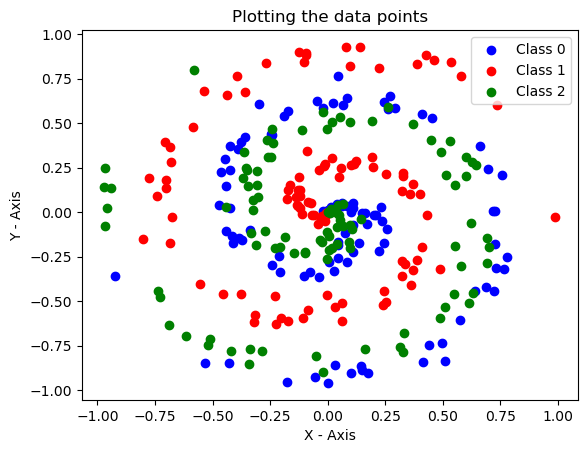

In [4]:
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0], c='blue', label='Class 0')
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c='red', label='Class 1')
plt.scatter(X[:, 0][y == 2], X[:, 1][y == 2], c='green', label='Class 2')
plt.xlabel('X - Axis')
plt.ylabel('Y - Axis')
plt.title('Plotting the data points')
plt.legend()
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_tain,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [6]:
class Dense:
    def __init__(self,no_of_inputs ,no_of_neurons):
        self.weights = np.random.randn(no_of_inputs, no_of_neurons) * 0.01
        self.biases = np.zeros((1, no_of_neurons))
        self.weights_momentum = np.zeros_like(self.weights)
        self.biases_momentum = np.zeros_like(self.biases)

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)


class ReluActivation:
    def forward(self, dense_output):
        self.inputs = dense_output
        self.output = np.maximum(0, dense_output)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs < 0] = 0


class Softmax:
    def forward(self, inputs):
        exp_inputs = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        sum_exp = np.sum(exp_inputs, axis=1, keepdims=True)
        self.output = exp_inputs / sum_exp
        return self.output


class CrossEntLoss:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            return -np.mean(np.log(y_pred[range(samples), y_true]))
        elif len(y_true.shape) == 2:
            return -np.mean(np.log(np.sum(y_pred * y_true, axis=1)))


class Softmax_CrossentLoss:
    def __init__(self):
        self.activation = Softmax()
        self.loss = CrossEntLoss()

    def forward(self, inputs, y_true):
        self.softmax_output = self.activation.forward(inputs)
        return self.loss.forward(self.softmax_output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs /= samples


In [7]:
class Optimizer_GD:
    def __init__(self,learning_rate = 1):
        self.learning_rate = learning_rate

    def update_param(self,layer):
        layer.weights -= self.learning_rate*layer.dweights
        layer.biases -= self.learning_rate*layer.dbiases


# Now creating the model


In [8]:
dense1 = Dense(2,64)
activation1 = ReluActivation()

dense2 = Dense(64,3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_GD()

In [9]:
for epochs in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = softmax_loss.forward(dense2.output,y)

    prediction = np.argmax(softmax_loss.softmax_output,axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y,axis=1)

    accuracy = np.mean(prediction == y)
    if epochs % 100 == 0:
        print(f'epochs = {epochs}, loss = {loss:.3f}, acc = {accuracy:.3f}')


    softmax_loss.backward(softmax_loss.softmax_output,y)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.update_param(dense1)
    optimizer.update_param(dense2)

    


epochs = 0, loss = 1.099, acc = 0.350
epochs = 100, loss = 1.076, acc = 0.450
epochs = 200, loss = 1.065, acc = 0.460
epochs = 300, loss = 1.063, acc = 0.453
epochs = 400, loss = 1.062, acc = 0.460
epochs = 500, loss = 1.060, acc = 0.460
epochs = 600, loss = 1.056, acc = 0.477
epochs = 700, loss = 1.050, acc = 0.470
epochs = 800, loss = 1.044, acc = 0.457
epochs = 900, loss = 1.043, acc = 0.440
epochs = 1000, loss = 1.034, acc = 0.427
epochs = 1100, loss = 1.025, acc = 0.403
epochs = 1200, loss = 1.016, acc = 0.410
epochs = 1300, loss = 1.020, acc = 0.447
epochs = 1400, loss = 1.022, acc = 0.423
epochs = 1500, loss = 1.001, acc = 0.440
epochs = 1600, loss = 0.995, acc = 0.447
epochs = 1700, loss = 0.997, acc = 0.447
epochs = 1800, loss = 0.990, acc = 0.493
epochs = 1900, loss = 0.989, acc = 0.457
epochs = 2000, loss = 0.986, acc = 0.507
epochs = 2100, loss = 0.985, acc = 0.480
epochs = 2200, loss = 0.984, acc = 0.460
epochs = 2300, loss = 0.987, acc = 0.487
epochs = 2400, loss = 0.977,

**Here our loss got stuck so we have to add decay to this grad descent**

### Now we will add the decay rate on our Optimizer

In [10]:
class Optimizer_SGD:
    def __init__(self,learning_rate = 1,decay=0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.current_learning_rate = learning_rate

    def update_param(self,layer):
        layer.weights -= self.learning_rate*layer.dweights
        layer.biases -= self.learning_rate*layer.dbiases

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate)/( 1+ self.decay*self.iteration)

    def post_update_params(self):
        self.iteration += 1

In [11]:
X,y = spiral_data(100,3)
dense1 = Dense(2,64)
activation1 = ReluActivation()

dense2 = Dense(64,3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_SGD(decay=1e-3)

for epochs in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    loss = softmax_loss.forward(dense2.output,y)

    prediction = np.argmax(softmax_loss.softmax_output,axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y,axis=1)

    accuracy = np.mean(prediction == y)
    if epochs % 100 == 0:
        print(f'epochs = {epochs}, loss = {loss:.3f}, acc = {accuracy:.3f}')


    softmax_loss.backward(softmax_loss.softmax_output,y)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)


    optimizer.pre_update_params()
    optimizer.update_param(dense1)
    optimizer.update_param(dense2)
    optimizer.post_update_params()

epochs = 0, loss = 1.099, acc = 0.363
epochs = 100, loss = 1.082, acc = 0.433
epochs = 200, loss = 1.071, acc = 0.433
epochs = 300, loss = 1.069, acc = 0.433
epochs = 400, loss = 1.068, acc = 0.440
epochs = 500, loss = 1.067, acc = 0.447
epochs = 600, loss = 1.066, acc = 0.453
epochs = 700, loss = 1.064, acc = 0.450
epochs = 800, loss = 1.059, acc = 0.447
epochs = 900, loss = 1.049, acc = 0.453
epochs = 1000, loss = 1.034, acc = 0.463
epochs = 1100, loss = 1.030, acc = 0.420
epochs = 1200, loss = 1.023, acc = 0.453
epochs = 1300, loss = 1.015, acc = 0.447
epochs = 1400, loss = 1.003, acc = 0.453
epochs = 1500, loss = 0.996, acc = 0.400
epochs = 1600, loss = 0.987, acc = 0.510
epochs = 1700, loss = 0.995, acc = 0.473
epochs = 1800, loss = 0.989, acc = 0.400
epochs = 1900, loss = 0.962, acc = 0.543
epochs = 2000, loss = 0.957, acc = 0.513
epochs = 2100, loss = 0.918, acc = 0.557
epochs = 2200, loss = 0.918, acc = 0.523
epochs = 2300, loss = 0.918, acc = 0.560
epochs = 2400, loss = 0.898,

### Adding the Mometum to reduce the number of epochs

In [12]:
class Optimizer_SGD:
    def __init__(self,learning_rate = 1,decay=0,momentum = 0.0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.iteration = 0
        self.current_learning_rate = learning_rate
        self.momentum = momentum

    def update_param(self,layer):
        if self.momentum:
            if not hasattr(layer,'weights_momentum'):
                layer.weights_momentum = np.zeros_like(layer.weights)
                layer.biases_momentum = np.zeros_like(layer.biases)

            weight_update = self.momentum*layer.weights_momentum - self.current_learning_rate * layer.dweights
            biases_update = self.momentum*layer.biases_momentum - self.current_learning_rate * layer.dbiases

            layer.weights_momentum = weight_update
            layer.biases_momentum = biases_update

        else:
            weight_update =  - self.current_learning_rate * layer.dweights
            biases_update = - self.current_learning_rate * layer.dbiases
                
        layer.weights += weight_update
        layer.biases += biases_update

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = (self.learning_rate)/( 1+ self.decay*self.iteration)

    def post_update_params(self):
        self.iteration += 1

In [13]:
dense1 = Dense(2,64)
activation1 = ReluActivation()

dense2 = Dense(64,3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_SGD(decay=1e-3,momentum=0.9)

for epochs in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    loss = softmax_loss.forward(dense2.output,y)

    prediction = np.argmax(softmax_loss.softmax_output,axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y,axis=1)

    accuracy = np.mean(prediction == y)
    if epochs % 100 == 0:
        print(f'epochs = {epochs}, loss = {loss:.3f}, acc = {accuracy:.3f}, lr = {optimizer.current_learning_rate}')


    softmax_loss.backward(softmax_loss.softmax_output,y)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)


    optimizer.pre_update_params()
    optimizer.update_param(dense1)
    optimizer.update_param(dense2)
    optimizer.post_update_params()

epochs = 0, loss = 1.099, acc = 0.377, lr = 1
epochs = 100, loss = 1.025, acc = 0.420, lr = 0.9099181073703367
epochs = 200, loss = 1.080, acc = 0.443, lr = 0.8340283569641367
epochs = 300, loss = 0.791, acc = 0.657, lr = 0.7698229407236336
epochs = 400, loss = 0.604, acc = 0.753, lr = 0.7147962830593281
epochs = 500, loss = 0.571, acc = 0.783, lr = 0.66711140760507
epochs = 600, loss = 0.394, acc = 0.863, lr = 0.6253908692933083
epochs = 700, loss = 0.345, acc = 0.887, lr = 0.5885815185403178
epochs = 800, loss = 0.317, acc = 0.883, lr = 0.5558643690939411
epochs = 900, loss = 0.317, acc = 0.883, lr = 0.526592943654555
epochs = 1000, loss = 0.292, acc = 0.897, lr = 0.5002501250625312
epochs = 1100, loss = 0.282, acc = 0.893, lr = 0.4764173415912339
epochs = 1200, loss = 0.294, acc = 0.867, lr = 0.45475216007276037
epochs = 1300, loss = 0.279, acc = 0.900, lr = 0.43497172683775553
epochs = 1400, loss = 0.308, acc = 0.857, lr = 0.4168403501458941
epochs = 1500, loss = 0.273, acc = 0.900

### Now using AGDAGRAD optimizer to update individual weights with different learning rates

In [14]:
class Optimizer_ADAGRAD:
    def __init__(self,learning_rate = 1,decay = 0,epsilon = 1e-7):
        self.learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.current_learning_rate = learning_rate
        self.iterations = 0

    def pre_update_params(self):
        self.current_learning_rate = self.learning_rate / (1 + self.decay*self.iterations)

    def update_params(self,layer):
        if not hasattr(layer,'weights_cache'):
                layer.weights_cache = np.zeros_like(layer.weights)
                layer.biases_cache = np.zeros_like(layer.biases)

        layer.weights_cache += layer.dweights ** 2
        layer.biases_cache += layer.dbiases ** 2

        layer.weights += -self.current_learning_rate*layer.dweights / (np.sqrt(layer.weights_cache + self.epsilon))
        layer.biases += -self.current_learning_rate*layer.dbiases / (np.sqrt(layer.biases_cache + self.epsilon))

    def post_update_params(self):
         self.iterations += 1

        
        

In [15]:
X,y = spiral_data(100,3)
dense1 = Dense(2,64)
activation1 = ReluActivation()

dense2 = Dense(64,3)
softmax_loss = Softmax_CrossentLoss()

optimizer = Optimizer_ADAGRAD(decay=1e-3)

for epochs in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    loss = softmax_loss.forward(dense2.output,y)

    prediction = np.argmax(softmax_loss.softmax_output,axis=1)
    if(len(y.shape) == 2):
        y = np.argmax(y,axis=1)

    accuracy = np.mean(prediction == y)
    if epochs % 100 == 0:
        print(f'epochs = {epochs}, loss = {loss:.3f}, acc = {accuracy:.3f}, lr = {optimizer.current_learning_rate}')


    softmax_loss.backward(softmax_loss.softmax_output,y)
    dense2.backward(softmax_loss.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)


    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epochs = 0, loss = 1.099, acc = 0.317, lr = 1
epochs = 100, loss = 1.045, acc = 0.383, lr = 0.9099181073703367
epochs = 200, loss = 1.033, acc = 0.403, lr = 0.8340283569641367
epochs = 300, loss = 1.010, acc = 0.453, lr = 0.7698229407236336
epochs = 400, loss = 0.983, acc = 0.500, lr = 0.7147962830593281
epochs = 500, loss = 0.967, acc = 0.510, lr = 0.66711140760507
epochs = 600, loss = 0.955, acc = 0.503, lr = 0.6253908692933083
epochs = 700, loss = 0.945, acc = 0.500, lr = 0.5885815185403178
epochs = 800, loss = 0.940, acc = 0.500, lr = 0.5558643690939411
epochs = 900, loss = 0.936, acc = 0.503, lr = 0.526592943654555
epochs = 1000, loss = 0.933, acc = 0.507, lr = 0.5002501250625312
epochs = 1100, loss = 0.930, acc = 0.503, lr = 0.4764173415912339
epochs = 1200, loss = 0.928, acc = 0.503, lr = 0.45475216007276037
epochs = 1300, loss = 0.927, acc = 0.513, lr = 0.43497172683775553
epochs = 1400, loss = 0.925, acc = 0.510, lr = 0.4168403501458941
epochs = 1500, loss = 0.924, acc = 0.510

In [16]:
# Choose a resolution
h = 0.01

# Create grid points based on your data range
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Flatten the grid and combine into input shape
grid = np.c_[xx.ravel(), yy.ravel()]


In [17]:
# Forward pass through trained model
dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
softmax_loss.forward(dense2.output, np.zeros(len(grid), dtype=int))
  # dummy labels



predictions = np.argmax(softmax_loss.softmax_output, axis=1)
Z = predictions.reshape(xx.shape)


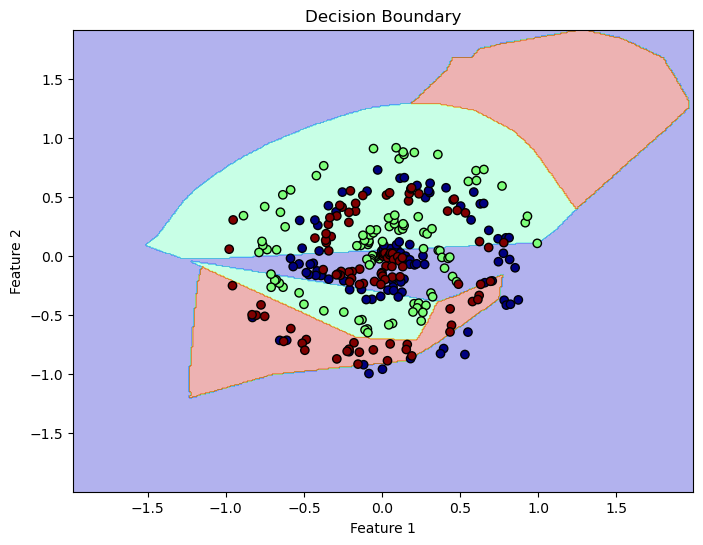

In [18]:
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap='jet', alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', edgecolors='k')
plt.title("Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()
